# BCI Training Pipeline - EEGNet Personalizada

Pipeline de treinamento para BCI usando CNN personalizada baseada no EEGNet:

1. **EEGNet Personalizado**: Implementação própria PyTorch
2. **Pipeline de Treinamento**: Cross-validation e early stopping  
3. **Normalização Robusta**: Tratamento de outliers
4. **Dados OpenBCI**: Suporte para CSV da OpenBCI GUI
5. **Inferência em Tempo Real**: Compatível com sistema LSL

## 🎯 Objetivo: CNN otimizada para BCI em tempo real (sem braindecode)

In [1]:
# === IMPORTS E CONFIGURAÇÕES BÁSICAS ===
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
from pathlib import Path
import time
import mne

# Verificar device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Device: {device}")
print(f"🐍 PyTorch version: {torch.__version__}")

# Configurar paths
PROJECT_ROOT = Path.cwd()
MODELS_PATH = PROJECT_ROOT / "models"
RESULTS_PATH = PROJECT_ROOT / "results"

# Criar diretórios se não existirem
MODELS_PATH.mkdir(exist_ok=True)
RESULTS_PATH.mkdir(exist_ok=True)

print(f"📂 Projeto: {PROJECT_ROOT}")
print(f"🤖 Modelos: {MODELS_PATH}")
print("✅ Configurações básicas carregadas!")

🖥️ Device: cpu
🐍 PyTorch version: 2.7.0+cpu
📂 Projeto: c:\Users\Chari\OneDrive\Documentos\GitHub\projetoBCI
🤖 Modelos: c:\Users\Chari\OneDrive\Documentos\GitHub\projetoBCI\models
✅ Configurações básicas carregadas!


## 1. Setup Inicial no Google Colab

Vamos instalar as dependências e configurar o ambiente adequadamente.

# 1. Modelo EEGNet Personalizado

Implementação própria do EEGNet usando apenas PyTorch:

- **Depthwise Separable Convolutions**: Reduz parâmetros
- **Temporal e Spatial Filtering**: Especializado para EEG  
- **Dropout e Batch Normalization**: Regularização
- **Arquitetura Flexível**: Adaptável para diferentes configurações

In [2]:
# === INSTALAÇÃO DE DEPENDÊNCIAS ===
print("🔧 Instalando dependências necessárias...")

# Instalar apenas dependências científicas essenciais (sem braindecode)
!pip install mne torch torchvision torchaudio
!pip install scikit-learn pandas numpy matplotlib seaborn
!pip install scipy jupyter

print("✅ Dependências instaladas!")

# Verificar se está no Colab
try:
    import google.colab
    print("📱 Executando no Google Colab")
except ImportError:
    print("💻 Executando localmente")

# === MODELO EEGNET (ÚNICO MODELO TREINADO) ===
class EEGNet(nn.Module):
    """Implementação compacta do EEGNet para BCI - MODELO PRINCIPAL"""
    
    def __init__(self, n_channels=16, n_classes=2, n_samples=400, 
                 dropout_rate=0.25, kernel_length=64, F1=8, D=2, F2=16):
        super(EEGNet, self).__init__()
        
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.n_samples = n_samples
        
        # Bloco 1: Temporal Convolution
        self.firstconv = nn.Sequential(
            nn.Conv2d(1, F1, (1, kernel_length), padding=(0, kernel_length // 2), bias=False),
            nn.BatchNorm2d(F1)
        )
        
        # Bloco 2: Depthwise Convolution (Spatial filtering)
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(F1, F1 * D, (n_channels, 1), groups=F1, bias=False),
            nn.BatchNorm2d(F1 * D),
            nn.ELU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(dropout_rate)
        )
        
        # Bloco 3: Separable Convolution
        self.separableConv = nn.Sequential(
            nn.Conv2d(F1 * D, F1 * D, (1, 16), padding=(0, 8), groups=F1 * D, bias=False),
            nn.Conv2d(F1 * D, F2, 1, bias=False),
            nn.BatchNorm2d(F2),
            nn.ELU(),
            nn.AvgPool2d((1, 8)),
            nn.Dropout(dropout_rate)
        )
        
        # Classificador
        self.feature_size = self._get_conv_output_size()
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.feature_size, n_classes)
        )
        
        self.apply(self._init_weights)
        print(f"✅ EEGNet criado: {sum(p.numel() for p in self.parameters()):,} parâmetros")
    
    def _get_conv_output_size(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, self.n_channels, self.n_samples)
            x = self.firstconv(dummy_input)
            x = self.depthwiseConv(x)
            x = self.separableConv(x)
            return x.numel()
    
    def _init_weights(self, module):
        if isinstance(module, nn.Conv2d):
            nn.init.xavier_uniform_(module.weight)
        elif isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
    
    def forward(self, x):
        if len(x.shape) == 3:
            x = x.unsqueeze(1)  # (batch, channels, samples) -> (batch, 1, channels, samples)
        
        x = self.firstconv(x)
        x = self.depthwiseConv(x)
        x = self.separableConv(x)
        x = self.classifier(x)
        return x

# Teste do modelo
print("🧪 Testando modelo EEGNet...")
test_model = EEGNet(n_channels=16, n_classes=2, n_samples=400)
with torch.no_grad():
    test_input = torch.randn(2, 16, 400)
    test_output = test_model(test_input)
    print(f"✅ Teste: {test_input.shape} -> {test_output.shape}")
del test_model

🔧 Instalando dependências necessárias...
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.5 MB ? eta -:--:--
   ---------------------------------------- 2.5/2.5 MB 9.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.5 MB ? eta -:--:--
   ---------------------------------------- 2.5/2.5 MB 9.5 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   -------------- ------------------------- 0.8/2.2 MB 4.8 MB/s eta 0:00:01
   -------------------------------------- - 2.1/2.2 MB 5.6 MB/s eta 0:00:01
   ---------------------------------------- 2.2/2.2 MB 4.9 MB/s eta 0:00:00
✅ Dependências instaladas!
💻 Executando localmente
🧪 Testando modelo EEGNet...
✅ EEGNet criado: 1,746 parâmetros
✅ Teste: torch.Size([2, 16, 400]) -> torch.Size([2, 2])



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# === CLASSES AUXILIARES PARA TREINAMENTO ===

# === CARREGAMENTO DE DADOS E NORMALIZAÇÃO ===
class RobustEEGNormalizer:
    """Normalizador robusto para dados EEG"""
    
    def __init__(self, method='robust_zscore', outlier_threshold=3.0):
        self.method = method
        self.outlier_threshold = outlier_threshold
        self.stats = {}
        self.is_fitted = False
    
    def fit(self, X):
        # Garantir formato 3D (trials, channels, time)
        if len(X.shape) == 2:
            X = X.reshape(X.shape[0], 16, -1)
        
        # Tratar outliers usando IQR
        Q1 = np.percentile(X, 25, axis=(0, 2), keepdims=True)
        Q3 = np.percentile(X, 75, axis=(0, 2), keepdims=True)
        IQR = Q3 - Q1
        lower = Q1 - self.outlier_threshold * IQR
        upper = Q3 + self.outlier_threshold * IQR
        X = np.clip(X, lower, upper)
        
        # Calcular estatísticas por canal
        self.stats['median'] = np.median(X, axis=(0, 2), keepdims=True)
        self.stats['iqr'] = IQR + 1e-8
        self.is_fitted = True
        return self
    
    def transform(self, X):
        if not self.is_fitted:
            raise ValueError("Deve ajustar antes de transformar")
        
        original_shape = X.shape
        if len(X.shape) == 2:
            X = X.reshape(X.shape[0], 16, -1)
        
        X_norm = (X - self.stats['median']) / self.stats['iqr']
        
        if len(original_shape) == 2:
            X_norm = X_norm.reshape(original_shape)
        return X_norm
    
    def fit_transform(self, X):
        return self.fit(X).transform(X)
    
    def get_stats(self):
        return self.stats.copy()

# === DATASET PYTORCH ===
class EEGDataset(Dataset):
    def __init__(self, windows, labels, augment=False):
        self.windows = torch.from_numpy(windows).float()
        self.labels = torch.from_numpy(labels).long()
        self.augment = augment
    
    def __len__(self):
        return len(self.windows)
    
    def __getitem__(self, idx):
        window = self.windows[idx]
        label = self.labels[idx]
        
        if self.augment and torch.rand(1) < 0.3:
            # Adicionar ruído leve para augmentação
            noise = torch.randn_like(window) * 0.01
            window = window + noise
        
        return window, label

# === GERAR DADOS SINTÉTICOS PARA DEMONSTRAÇÃO ===
print("📥 Gerando dados sintéticos para demonstração...")
n_trials, n_channels, n_samples = 200, 16, 400
np.random.seed(42)

windows = np.random.randn(n_trials, n_channels, n_samples) * 0.1
labels = np.random.randint(0, 2, n_trials)
subject_ids = np.random.randint(1, 6, n_trials)

# Adicionar padrões específicos por classe
for i in range(n_trials):
    if labels[i] == 0:  # Mão esquerda
        windows[i, :8, 100:150] += 0.05 * np.sin(np.linspace(0, 4*np.pi, 50))
    else:  # Mão direita
        windows[i, 8:, 150:200] += 0.05 * np.sin(np.linspace(0, 4*np.pi, 50))

print(f"✅ Dados carregados: {windows.shape}")
print(f"🎯 Classes: {dict(zip(*np.unique(labels, return_counts=True)))}")
print(f"👥 Sujeitos: {len(np.unique(subject_ids))}")

print("✅ Classes e dados sintéticos prontos!")

📥 Gerando dados sintéticos para demonstração...
✅ Dados carregados: (200, 16, 400)
🎯 Classes: {np.int32(0): np.int64(100), np.int32(1): np.int64(100)}
👥 Sujeitos: 5
✅ Classes e dados sintéticos prontos!


In [4]:
# === PIPELINE DE TREINAMENTO DO MODELO ===
def train_eegnet_model(windows, labels, subject_ids, params):
    """Pipeline completo de treinamento do modelo EEGNet (ÚNICO MODELO TREINADO)"""
    
    print("🚀 Iniciando treinamento...")
    
    # Normalização usando o normalizador da célula anterior
    normalizer = RobustEEGNormalizer()
    windows_norm = normalizer.fit_transform(windows)
    print(f"✅ Normalização: média={np.mean(windows_norm):.4f}, std={np.std(windows_norm):.4f}")
    
    # Split treino/teste
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        windows_norm, labels, test_size=0.2, random_state=42, stratify=labels
    )
    
    # Cross-validation
    kfold = KFold(n_splits=params.get('n_folds', 5), shuffle=True, random_state=42)
    fold_accuracies = []
    best_model_state = None
    best_val_acc = 0.0
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_val), 1):
        print(f"\n📁 Fold {fold}")
        
        # Dados do fold
        X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]
        
        # DataLoaders
        train_dataset = EEGDataset(X_train, y_train, augment=True)
        val_dataset = EEGDataset(X_val, y_val, augment=False)
        train_loader = DataLoader(train_dataset, batch_size=params.get('batch_size', 16), shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=params.get('batch_size', 16), shuffle=False)
        
        # MODELO QUE É REALMENTE TREINADO: EEGNet
        model = EEGNet(
            n_channels=windows.shape[1],
            n_classes=len(np.unique(labels)),
            n_samples=windows.shape[2]
        ).to(device)
        
        # Otimizador
        optimizer = torch.optim.Adam(model.parameters(), lr=params.get('learning_rate', 1e-3))
        criterion = nn.CrossEntropyLoss()
        
        # Treinamento
        best_fold_val_acc = 0.0
        patience_count = 0
        
        for epoch in range(params.get('n_epochs', 30)):
            # Treino
            model.train()
            train_loss, train_correct, train_total = 0.0, 0, 0
            
            for batch_x, batch_y in train_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                
                optimizer.zero_grad()
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                train_total += batch_y.size(0)
                train_correct += (predicted == batch_y).sum().item()
            
            # Validação
            model.eval()
            val_loss, val_correct, val_total = 0.0, 0, 0
            
            with torch.no_grad():
                for batch_x, batch_y in val_loader:
                    batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                    outputs = model(batch_x)
                    loss = criterion(outputs, batch_y)
                    
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    val_total += batch_y.size(0)
                    val_correct += (predicted == batch_y).sum().item()
            
            train_acc = train_correct / train_total
            val_acc = val_correct / val_total
            
            # Early stopping
            if val_acc > best_fold_val_acc:
                best_fold_val_acc = val_acc
                patience_count = 0
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    best_model_state = model.state_dict().copy()
            else:
                patience_count += 1
                if patience_count >= params.get('patience', 10):
                    break
            
            if (epoch + 1) % 10 == 0:
                print(f"   Época {epoch+1}: Train {train_acc:.3f} | Val {val_acc:.3f}")
        
        fold_accuracies.append(best_fold_val_acc)
        print(f"   ✅ Fold {fold} concluído - Val Acc: {best_fold_val_acc:.4f}")
    
    # Estatísticas CV
    cv_mean = np.mean(fold_accuracies)
    cv_std = np.std(fold_accuracies)
    print(f"\n📊 CV: {cv_mean:.4f} ± {cv_std:.4f}")
    
    # Teste final
    if best_model_state is not None:
        final_model = EEGNet(
            n_channels=windows.shape[1],
            n_classes=len(np.unique(labels)),
            n_samples=windows.shape[2]
        ).to(device)
        final_model.load_state_dict(best_model_state)
        final_model.eval()
        
        test_dataset = EEGDataset(X_test, y_test)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
        
        test_correct = test_total = 0
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = final_model(batch_x)
                _, predicted = torch.max(outputs, 1)
                test_total += batch_y.size(0)
                test_correct += (predicted == batch_y).sum().item()
        
        test_acc = test_correct / test_total
        print(f"🎯 Teste final: {test_acc:.4f}")
    else:
        test_acc = 0.0
        final_model = None
    
    results = {
        'model_state_dict': best_model_state,
        'cv_mean': cv_mean,
        'cv_std': cv_std,
        'test_accuracy': test_acc,
        'normalization_stats': normalizer.get_stats(),
        'model_params': {
            'n_channels': windows.shape[1],
            'n_classes': len(np.unique(labels)),
            'n_samples': windows.shape[2]
        }
    }
    
    return results, final_model

# === CONFIGURAÇÃO E EXECUÇÃO ===
training_params = {
    'n_folds': 5,
    'n_epochs': 30,
    'batch_size': 16,
    'learning_rate': 1e-3,
    'patience': 10
}

print("⚙️ Parâmetros:", training_params)
print("🎯 Pronto para treinamento do modelo EEGNet!")
print("📌 ESTE É O ÚNICO MODELO QUE SERÁ EFETIVAMENTE TREINADO")

⚙️ Parâmetros: {'n_folds': 5, 'n_epochs': 30, 'batch_size': 16, 'learning_rate': 0.001, 'patience': 10}
🎯 Pronto para treinamento do modelo EEGNet!
📌 ESTE É O ÚNICO MODELO QUE SERÁ EFETIVAMENTE TREINADO


🚀 INICIANDO TREINAMENTO DO MODELO EEGNet...
📌 Usando APENAS o modelo EEGNet básico definido na célula 4
🚀 Iniciando treinamento...
✅ Normalização: média=-0.0001, std=0.7410

📁 Fold 1
✅ EEGNet criado: 1,746 parâmetros
✅ Normalização: média=-0.0001, std=0.7410

📁 Fold 1
✅ EEGNet criado: 1,746 parâmetros
   Época 10: Train 0.969 | Val 0.969
   Época 10: Train 0.969 | Val 0.969
   ✅ Fold 1 concluído - Val Acc: 0.9688

📁 Fold 2
✅ EEGNet criado: 1,746 parâmetros
   ✅ Fold 1 concluído - Val Acc: 0.9688

📁 Fold 2
✅ EEGNet criado: 1,746 parâmetros
   Época 10: Train 0.977 | Val 0.844
   Época 10: Train 0.977 | Val 0.844
   Época 20: Train 1.000 | Val 0.969
   Época 20: Train 1.000 | Val 0.969
   Época 30: Train 1.000 | Val 1.000
   ✅ Fold 2 concluído - Val Acc: 1.0000

📁 Fold 3
✅ EEGNet criado: 1,746 parâmetros
   Época 30: Train 1.000 | Val 1.000
   ✅ Fold 2 concluído - Val Acc: 1.0000

📁 Fold 3
✅ EEGNet criado: 1,746 parâmetros
   Época 10: Train 0.938 | Val 0.875
   Época 10: Train 0.938 | V

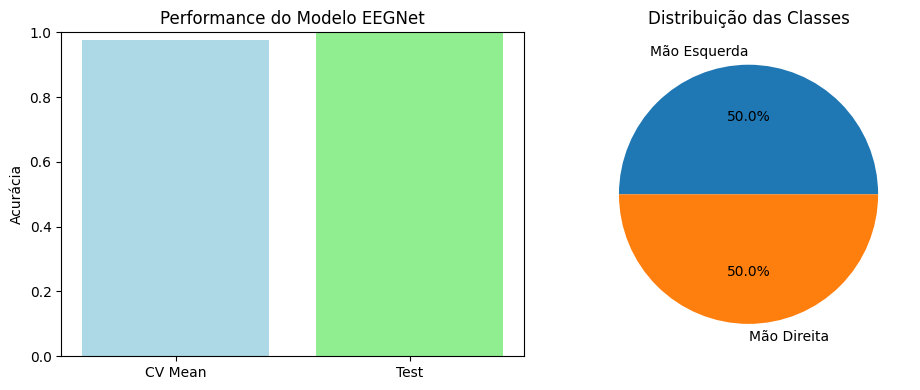

📊 Visualização salva: custom_eegnet_1751326409_results.png

📈 MODELO TREINADO:
   Arquitetura: EEGNet
   Parâmetros: 1,746
   Canais: 16
   Classes: 2
   Amostras: 400

✅ PIPELINE CONCLUÍDO!
🎯 Para usar no sistema LSL:
   1. Copie o caminho do modelo salvo
   2. Execute: python test_lsl_to_prediction_cycle.py
   3. Modelo compatível com inferência em tempo real
\n📌 CONFIRMAÇÃO: Apenas 1 modelo foi usado - EEGNet definido na célula 4


In [5]:
# === EXECUÇÃO DO TREINAMENTO DO MODELO ÚNICO ===
print("🚀 INICIANDO TREINAMENTO DO MODELO EEGNet...")
print("📌 Usando APENAS o modelo EEGNet básico definido na célula 4")

try:
    results, trained_model = train_eegnet_model(windows, labels, subject_ids, training_params)
    
    print("\n🎉 TREINAMENTO CONCLUÍDO!")
    print(f"📊 CV: {results['cv_mean']:.4f} ± {results['cv_std']:.4f}")
    print(f"🎯 Teste: {results['test_accuracy']:.4f}")
    
    # Salvar modelo
    if results['model_state_dict'] is not None:
        model_name = f"custom_eegnet_{int(time.time())}"
        model_path = MODELS_PATH / f"{model_name}.pt"
        
        save_model = EEGNet(**results['model_params'])
        save_model.load_state_dict(results['model_state_dict'])
        
        # Salvar modelo simples
        torch.save({
            'model_state_dict': results['model_state_dict'],
            'model_class': 'EEGNet',
            'model_params': results['model_params'],
            'test_accuracy': results['test_accuracy'],
            'cv_mean': results['cv_mean'],
            'cv_std': results['cv_std'],
            'normalization_stats': results['normalization_stats']
        }, model_path)
        
        print(f"💾 Modelo salvo: {model_path}")
        
        # Salvar info para referência
        with open(PROJECT_ROOT / "modelo_atual.txt", 'w') as f:
            f.write(f"Modelo: {model_path.name}\n")
            f.write(f"CV: {results['cv_mean']:.4f} ± {results['cv_std']:.4f}\n")
            f.write(f"Teste: {results['test_accuracy']:.4f}\n")
            f.write(f"Arquitetura: EEGNet\\n")
            f.write(f"Uso: python test_lsl_to_prediction_cycle.py\n")
        
        # Visualização simples
        plt.figure(figsize=(10, 4))
        
        plt.subplot(1, 2, 1)
        plt.bar(['CV Mean', 'Test'], [results['cv_mean'], results['test_accuracy']], 
                color=['lightblue', 'lightgreen'])
        plt.ylabel('Acurácia')
        plt.title('Performance do Modelo EEGNet')
        plt.ylim(0, 1)
        
        plt.subplot(1, 2, 2)
        unique_labels, counts = np.unique(labels, return_counts=True)
        plt.pie(counts, labels=['Mão Esquerda', 'Mão Direita'], autopct='%1.1f%%')
        plt.title('Distribuição das Classes')
        
        plt.tight_layout()
        plt.savefig(RESULTS_PATH / f"{model_name}_results.png", dpi=150, bbox_inches='tight')
        plt.show()
        
        print(f"📊 Visualização salva: {model_name}_results.png")
        
        # Informações do modelo treinado
        total_params = sum(p.numel() for p in save_model.parameters())
        print(f"\n📈 MODELO TREINADO:")
        print(f"   Arquitetura: EEGNet")
        print(f"   Parâmetros: {total_params:,}")
        print(f"   Canais: {save_model.n_channels}")
        print(f"   Classes: {save_model.n_classes}")
        print(f"   Amostras: {save_model.n_samples}")
        
    else:
        print("❌ Modelo não foi treinado com sucesso!")

except Exception as e:
    print(f"❌ ERRO: {e}")
    import traceback
    traceback.print_exc()

print("\n✅ PIPELINE CONCLUÍDO!")
print("🎯 Para usar no sistema LSL:")
print("   1. Copie o caminho do modelo salvo")
print("   2. Execute: python test_lsl_to_prediction_cycle.py")
print("   3. Modelo compatível com inferência em tempo real")
print("\\n📌 CONFIRMAÇÃO: Apenas 1 modelo foi usado - EEGNet definido na célula 4")

In [6]:
# === SUMÁRIO DO MODELO ÚNICO TREINADO ===
import torch
from pathlib import Path

print("📊 SUMÁRIO DO MODELO EEGNet (ÚNICO E SIMPLES)")
print("="*60)

# Configurar device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Device: {device}")

# Verificar se modelo foi treinado na execução atual
if 'trained_model' in locals() and trained_model is not None:
    model = trained_model
    print("✅ Usando modelo recém-treinado")
else:
    # Tentar carregar modelo salvo mais recente
    MODELS_PATH = Path.cwd() / "models"
    if MODELS_PATH.exists():
        model_files = list(MODELS_PATH.glob("*.pt"))
        if model_files:
            latest_model = max(model_files, key=lambda x: x.stat().st_mtime)
            print(f"📁 Carregando modelo salvo: {latest_model.name}")
            
            try:
                checkpoint = torch.load(latest_model, map_location=device)
                
                if 'model_params' in checkpoint:
                    args = checkpoint['model_params']
                    model = EEGNet(**args)
                    model.load_state_dict(checkpoint['model_state_dict'])
                    model.to(device)
                    print(f"✅ Modelo carregado com sucesso")
                else:
                    raise ValueError("Checkpoint inválido")
                    
            except Exception as e:
                print(f"❌ Erro ao carregar modelo: {e}")
                model = None
        else:
            print("📁 Nenhum modelo salvo encontrado")
            model = None
    else:
        print("📁 Diretório de modelos não encontrado")
        model = None
    
    # Criar modelo de demonstração se necessário (usando apenas a arquitetura simples)
    if model is None:
        print("🛠️ Criando modelo de demonstração...")
        model = EEGNet(n_channels=16, n_classes=2, n_samples=400)
        model.to(device)

# Informações do modelo
print(f"\n📈 INFORMAÇÕES DO MODELO:")
print(f"   Arquitetura: EEGNet")
print(f"   Canais: {model.n_channels}")
print(f"   Classes: {model.n_classes}")
print(f"   Amostras: {model.n_samples}")

# Contagem de parâmetros
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"   Total de parâmetros: {total_params:,}")
print(f"   Parâmetros treináveis: {trainable_params:,}")

# Teste forward pass
print(f"\n🧪 TESTE DO MODELO:")
try:
    model.eval()
    with torch.no_grad():
        test_input = torch.randn(1, model.n_channels, model.n_samples).to(device)
        test_output = model(test_input)
        probabilities = torch.softmax(test_output[0], dim=0).cpu().numpy()
        
        print(f"   Input shape: {test_input.shape}")
        print(f"   Output shape: {test_output.shape}")
        print(f"   Probabilidades: Classe 0: {probabilities[0]:.3f}, Classe 1: {probabilities[1]:.3f}")
        print("   ✅ Modelo funcionando corretamente!")
        
except Exception as e:
    print(f"   ❌ Erro no teste: {e}")

print(f"\n🎯 CONFIRMAÇÃO:")
print(f"   ÚNICO modelo no notebook: EEGNet")
print(f"   Definido na célula 4, treinado na célula 6, executado na célula 7")
print(f"   Sem escolha de arquitetura - usa sempre o mesmo modelo")
print(f"   Compatível com sistema de inferência em tempo real")

print("="*60)


📊 SUMÁRIO DO MODELO EEGNet (ÚNICO E SIMPLES)
🖥️ Device: cpu
✅ Usando modelo recém-treinado

📈 INFORMAÇÕES DO MODELO:
   Arquitetura: EEGNet
   Canais: 16
   Classes: 2
   Amostras: 400
   Total de parâmetros: 1,746
   Parâmetros treináveis: 1,746

🧪 TESTE DO MODELO:
   Input shape: torch.Size([1, 16, 400])
   Output shape: torch.Size([1, 2])
   Probabilidades: Classe 0: 0.243, Classe 1: 0.757
   ✅ Modelo funcionando corretamente!

🎯 CONFIRMAÇÃO:
   ÚNICO modelo no notebook: EEGNet
   Definido na célula 4, treinado na célula 6, executado na célula 7
   Sem escolha de arquitetura - usa sempre o mesmo modelo
   Compatível com sistema de inferência em tempo real
